<a href="https://colab.research.google.com/github/DIFACQUIM/Cursos/blob/main/4_2_API_ChEMBL_FQ_corto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

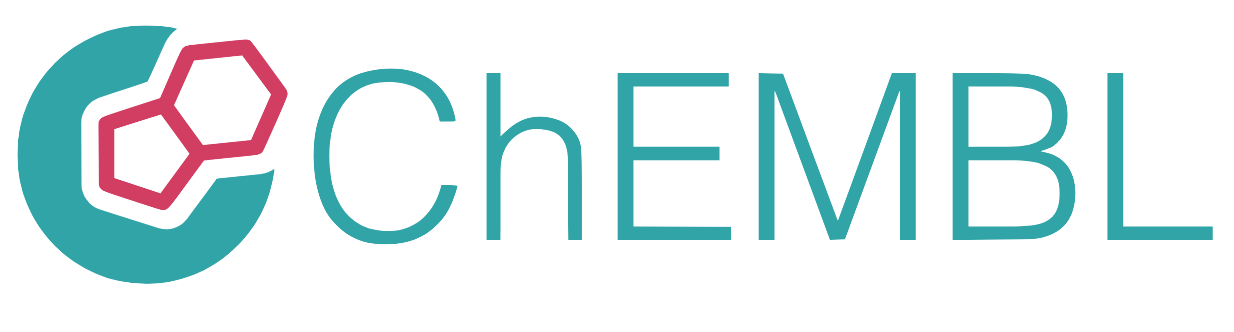



---
**Realizado por:** Raziel Cedillo

**Contacto:** brayanraziel1997@gmail.com

**Actualización:** Junio 2024

---

# **ChEMBL** (*Obtención de datos y ejemplos*)


---



Las siguientes paqueterias y herramientas quimioinformáticas nos ayudan a acceder a los datos de ChEMBL:
*   chembl_webresource_client
*   Pandas
*   RDKit

## **Glosario**
1. [Moléculas](#0)
2. [Fármacos](#1)
3. [Blancos moleculares](#2)
4. [Actividades](#3)
5. [Ensayos](#4)
6. [Utilidades](#5)
7. [Ejercicio global.](#6)

En grandes rasgos, para realizar una búsqueda en ChEMBL a través de la API, requerimos en principio tres cosas:
  1. el ***módulo*** de búsqueda ("new_client")
  2. el ***recurso*** disponible a emplear
  3. la ***palabra clave*** que nos permitirá aplicar un filtro

Adicionalmente se pueden aplicar filtros extra.

---

## **Paqueterias**: instalación e importación
---


In [2]:
from IPython.utils import io #Proporciona herramientas para capturar y suprimir las salidas (outputs).
import tqdm.notebook #Proporciona una barra de progreso interactiva para el notebook Jupyter.
import os, os.path, sys, random, subprocess #Proporciona funciones para interactuar con el sistema operativo, como manipular archivos y directorios.
total = 100
with tqdm.notebook.tqdm(total=total) as pbar:
    with io.capture_output() as captured:
        pbar.update(20)
        !pip install matplotlib, seaborn, pandas, bs4
        import requests # Web Scrapping
        from bs4 import BeautifulSoup # Web Scrapping

        '''Librerías gráficas'''
        import matplotlib.pyplot as plt
        from IPython.display import display, SVG, HTML #Muestra gráficos SVG en el notebook
        import seaborn as sns #Librería para visualización de datos estadísticos basada en matplotlib.
        !pip install rdkit
        from rdkit import Chem
        from rdkit.Chem import Draw
        pbar.update(40)
        '''Librerias de herramientas primarias:'''
        import pandas as pd #Librería para manipulación y análisis de datos tabulares en Python.
        %config Completer.use_jedi = False #Jupyter
        import json #Proporciona herramientas para trabajar con datos en formato JSON.
        pbar.update(30)
        '''Busqueda en ChEMBL (API)'''
        !pip install chembl_webresource_client
        from chembl_webresource_client.new_client import new_client #Proporciona un nuevo cliente para acceder a la API de ChEMBL.
        from chembl_webresource_client.utils import utils #Proporciona funciones de utilidad para trabajar con la API de ChEMBL.
        from pathlib import Path #Proporciona manipulación de rutas de archivos como clases independientes.
        '''Montar unidad de Google Drive'''
        #from google.colab import drive #Proporciona herramientas para montar y acceder a Google Drive desde Google Colab.
        #drive.mount("/content/drive")
        #pbar.update(10)

  0%|          | 0/100 [00:00<?, ?it/s]

---

## **Estructura de una búsqueda general**

---


En la siguiente figura se ejemplifica visualmente una búsqueda a través de la interfaz gráfica de ChEMBL (lado izquierdo) en comparación con una realizada a través de la API (lado derecho).

En la primera sección de ambas metodologías se realiza la búsqueda de la palabra "aspirina" ("aspirin", en color azul).
En la segunda sección, se realiza la búsqueda de un identificador de ChEMBL asociado a la aspirina (CHEMBL25, en color verde).


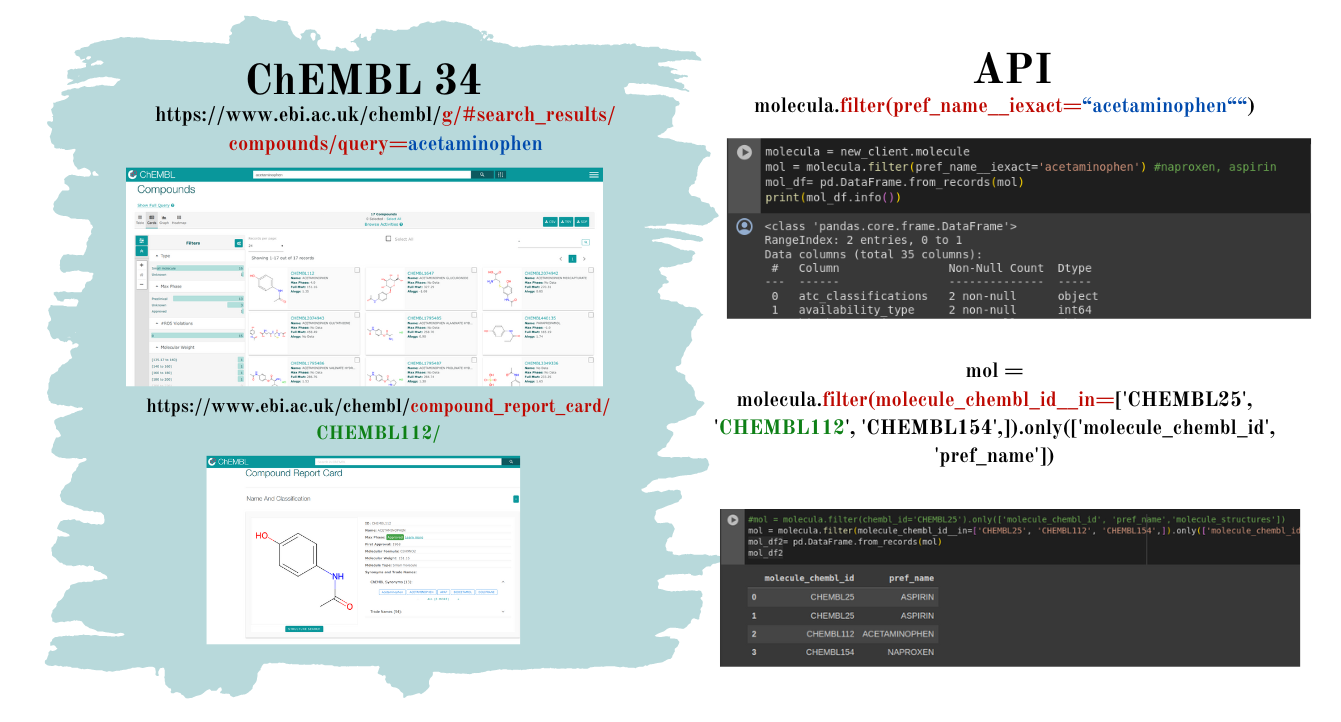

En las siguientes líneas de código se muestra como se realiza la búsqueda de la información asociada a la palabra "aspirin" en ChEMBL a través del uso de la API "new_client".

---
## **Recursos disponibles a través de la API (*endpoints*)**
---

La API de ChEMBL nos ofrece una serie de módulos, a través de los cuales se puede obtener una amplia gama de información. Esta información puede ser filtrada empleando una serie de herramientas y palabras clave que se abordarán en las siguientes secciones.

Las líneas de código que se encuentran a continuación enlistan los diferentes módulos que se pueden emplear a partir del uso de la API. En el mismo sentido, cada fila representa la estructura en programación para generar la llamada del módulo deseado en python (por ejemplo: `actividad = new_client.activity`)

In [3]:
# Obtener los recursos disponibles en new_client
recursos = [rec for rec in dir(new_client) if not rec.startswith('_')]
print(recursos)

# Crear un DataFrame con los recursos disponibles
recursos_disponibles = pd.DataFrame({
    'resource': recursos,
    'sintaxis': ['new_client.' + rec for rec in recursos],
    'url': [f"https://www.ebi.ac.uk/chembl/api/data/{rec}/schema" for rec in recursos]
    })

# Convertir el DataFrame a formato HTML
html = recursos_disponibles.to_html(render_links=True, escape=False)

# Mostrar el DataFrame en formato HTML
HTML(html)


['activity', 'activity_supplementary_data_by_activity', 'assay', 'assay_class', 'atc_class', 'binding_site', 'biotherapeutic', 'cell_line', 'chembl_id_lookup', 'chembl_release', 'compound_record', 'compound_structural_alert', 'description', 'document', 'document_similarity', 'drug', 'drug_indication', 'drug_warning', 'go_slim', 'image', 'mechanism', 'metabolism', 'molecule', 'molecule_form', 'official', 'organism', 'protein_classification', 'similarity', 'source', 'substructure', 'target', 'target_component', 'target_relation', 'tissue', 'xref_source']


,resource,sintaxis,url
0,activity,new_client.activity,https://www.ebi.ac.uk/chembl/api/data/activity/schema
1,activity_supplementary_data_by_activity,new_client.activity_supplementary_data_by_activity,https://www.ebi.ac.uk/chembl/api/data/activity_supplementary_data_by_activity/schema
2,assay,new_client.assay,https://www.ebi.ac.uk/chembl/api/data/assay/schema
3,assay_class,new_client.assay_class,https://www.ebi.ac.uk/chembl/api/data/assay_class/schema
4,atc_class,new_client.atc_class,https://www.ebi.ac.uk/chembl/api/data/atc_class/schema
5,binding_site,new_client.binding_site,https://www.ebi.ac.uk/chembl/api/data/binding_site/schema
6,biotherapeutic,new_client.biotherapeutic,https://www.ebi.ac.uk/chembl/api/data/biotherapeutic/schema
7,cell_line,new_client.cell_line,https://www.ebi.ac.uk/chembl/api/data/cell_line/schema
8,chembl_id_lookup,new_client.chembl_id_lookup,https://www.ebi.ac.uk/chembl/api/data/chembl_id_lookup/schema
9,chembl_release,new_client.chembl_release,https://www.ebi.ac.uk/chembl/api/data/chembl_release/schema


In [4]:
def extract_fields_info(fields_node):
    """Extrae el nombre y la descripción de los campos de un nodo de campos dado."""
    fields_info = []
    for field in fields_node.find_all(recursive=False):
        field_name = field.name.strip().upper() if field.name else 'UNKNOWN'
        help_text = field.find('help_text').text.strip() if field.find('help_text') else 'No help text provided'
        fields_info.append(f"{field_name}: {help_text}")
    return fields_info

def extract_info_from_resource(url, nombre_recurso):
    """Extrae la información completa acerca del nombre y la descripción de los campos
    de interés a partir de un formato XML."""

    response = requests.get(url)
    if response.status_code != 200:
        print(f"Error fetching {url}: Status code {response.status_code}")
        return pd.DataFrame()

    soup = BeautifulSoup(response.text, features="xml")
    fields = soup.find('fields')

    if fields is None:
        print(f"No 'fields' node found in {url}")
        return pd.DataFrame()

    data = []
    for field in fields.find_all(recursive=False):
        field_name = field.name.strip().upper() if field.name else 'UNKNOWN'
        help_text = field.find('help_text').text.strip() if field.find('help_text') else 'No help text provided'
        nested_fields_info = []
        nested_fields_node = field.find('fields')
        if nested_fields_node:
            nested_fields_info = extract_fields_info(nested_fields_node)

        data.append({
            'Name': field_name,
            'Info': help_text,
            'Nested_Info': '; '.join(nested_fields_info) if nested_fields_info else 'No nested info',
            'sintaxis': nombre_recurso+'__'+field_name.lower()

        })

    table = pd.DataFrame(data)
    return table

# Inicializar lista para almacenar los resultados de cada recurso
resultados = []

# Iterar sobre cada fila del DataFrame
for idx, row in recursos_disponibles.iterrows():
    nombre_recurso = row['resource']
    url = row['url']
    print(f"Procesando URL: {url}")
    table = extract_info_from_resource(url,nombre_recurso )
    resultados.append((row['resource'], table))

Procesando URL: https://www.ebi.ac.uk/chembl/api/data/activity/schema
Procesando URL: https://www.ebi.ac.uk/chembl/api/data/activity_supplementary_data_by_activity/schema
Procesando URL: https://www.ebi.ac.uk/chembl/api/data/assay/schema
Procesando URL: https://www.ebi.ac.uk/chembl/api/data/assay_class/schema
Procesando URL: https://www.ebi.ac.uk/chembl/api/data/atc_class/schema
Procesando URL: https://www.ebi.ac.uk/chembl/api/data/binding_site/schema
Procesando URL: https://www.ebi.ac.uk/chembl/api/data/biotherapeutic/schema
Procesando URL: https://www.ebi.ac.uk/chembl/api/data/cell_line/schema
Procesando URL: https://www.ebi.ac.uk/chembl/api/data/chembl_id_lookup/schema
Procesando URL: https://www.ebi.ac.uk/chembl/api/data/chembl_release/schema
Procesando URL: https://www.ebi.ac.uk/chembl/api/data/compound_record/schema
Procesando URL: https://www.ebi.ac.uk/chembl/api/data/compound_structural_alert/schema
Procesando URL: https://www.ebi.ac.uk/chembl/api/data/description/schema
Error 

In [6]:
nombre_recurso, table = resultados[22]
print(f"\nResultados para el recurso: {nombre_recurso}")
table


Resultados para el recurso: molecule


,Name,Info,Nested_Info,sintaxis
0,ATC_CLASSIFICATIONS,Many related resources. Can be either a list o...,LEVEL1: First level of classification; LEVEL1_...,molecule__atc_classifications
1,AVAILABILITY_TYPE,The availability type for the drug (0 = discon...,No nested info,molecule__availability_type
2,BIOTHERAPEUTIC,A single related resource. Can be either a URI...,BIOCOMPONENTS: Many related resources. Can be ...,molecule__biotherapeutic
3,BLACK_BOX_WARNING,Indicates that the drug has a black box warning,No nested info,molecule__black_box_warning
4,CHEMICAL_PROBE,Indicates whether the compound is a chemical p...,No nested info,molecule__chemical_probe
5,CHIRALITY,Shows whether a drug is dosed as a racemic mix...,No nested info,molecule__chirality
6,CROSS_REFERENCES,Many related resources. Can be either a list o...,XREF_ID: Identifier for the entry in the cross...,molecule__cross_references
7,DOSED_INGREDIENT,Indicates that the drug is dosed in this form ...,No nested info,molecule__dosed_ingredient
8,FIRST_APPROVAL,Earliest known approval year for the molecule,No nested info,molecule__first_approval
9,FIRST_IN_CLASS,Indicates whether this is known to be the firs...,No nested info,molecule__first_in_class


Puedes consultar el esquema por cada endpoint considerando la siguiente estructura:

**https://www.ebi.ac.uk/chembl/api/data/X/schema**

Intercambiando la X por cualquier endpoint.
ejemplo: https://www.ebi.ac.uk/chembl/api/data/tissue/schema

---
## **Filtros disponibles (palabras clave)**
---
Existe una amplia variedad de filtros para el módulo "new_client" que nos permiten afinar las búsquedas a partir de palabras clave, las cuales son:

*   ***iexact***. Permite realizar una búsqueda sin distinguir entre mayúsculas y minúsculas.
*   ***contains***. Busca objetos que contengan un valor específico.
 *   ***icontains***. Similar a contains, pero sin distinguir entre mayúsculas y minúsculas.
*   ***in***. Busca objetos cuyo valor esté dentro de una lista de valores.

---------------------Comparaciones numéricas---------------------
 * ***gt*** (mayor que)
  * ***gte*** (mayor o igual que)
 * ***lt*** (menor que)
  * ***lte*** (menor o igual que).

----------------Comparaciones de cadena de texto----------------
 *   ***startswith***. Comienza con.
  *   ***istartswith***. Comienza con, sin distinguir entre mayúsculas y minúsculas.
 *   ***endswith***. Termina con.
  *   ***iendswith***. Termina con, sin distinguir entre mayúsculas y minúsculas.

*   ***range***. Permite buscar objetos cuyo valor esté dentro de un rango específico.
*   ***isnull***. Permite buscar objetos que tengan un campo nulo (True) o no (False).
*   ***regex***.  Permite realizar búsquedas utilizando expresiones regulares.(r'^[A-Za-z]+$', buscará objetos cuyo nombre consiste solo de letras).
 *   ***iregex***. Similar a regex, pero sin distinguir entre mayúsculas y minúsculas en la búsqueda.
----------------------------------------------------------------------
Lo anterior se permite debido a que esta API se encuentra construido a partir de Django (https://docs.djangoproject.com/en/1.11/ref/models/querysets).


## ***Doble guión bajo: __***
Es usado para emplear las palabras claves para afinar la búsqueda.

## ***Operador: only***
Only es un método que limita los resultados con base en un conjunto seleccionado de campos para una base de datos. Este método toma una lista de campos (como un solo argumento) para ser incluidos en los resultados. Al usar only se hace un llamamiento a la API de forma rápida debido a que se toma una menor cantidad de información.
Nota: cualquier campo especificado ignorará los campos anidados ("logP" es equivalente a "propiedades moleculares")


| Operador     | Significado        | Ejemplo                  |
| ------------ | ------------------ | ------------------------ |
| `gt`         | Mayor que          | `mw__gt=300`             |
| `lt`         | Menor que          | `value__lt=10`           |
| `gte`        | ≥                  | `pchembl__gte=6`         |
| `lte`        | ≤                  | `pchembl__lte=8`         |
| `exact`      | Exacto             | `id__exact=CHEMBL25`     |
| `startswith` | Empieza con        | `id__startswith=CHEMBL`  |
| `contains`   | Contiene           | `name__contains=kinase`  |
| `icontains`  | Contiene (no case) | `name__icontains=kinase` |
| `in`         | En lista           | `type__in=IC50,Ki`       |


---
---

<a name='0'></a>
# ***1. Moléculas***
---
---


Este modulo (*molecule*) usualmente tienen asociados datos de bioactividad.




## Búsquedas:

### ***Nombre / sinónimo / ID / representación***

In [14]:
molecula = new_client.molecule
mol = molecula.filter(pref_name__iexact='acetaminophen') #naproxen, aspirin
print(mol)
#print(type(mol))
mol_df= pd.DataFrame.from_records(mol)
display(mol_df)
print(mol_df.info())

[{'atc_classifications': ['N02BE51', 'N02BE01', 'N02BE71'], 'availability_type': 2, 'biotherapeutic': None, 'black_box_warning': 1, 'chemical_probe': 0, 'chirality': 2, 'cross_references': [{'xref_id': 'acetaminophen', 'xref_name': 'acetaminophen', 'xref_src': 'DailyMed'}], 'dosed_ingredient': True, 'first_approval': 1968, 'first_in_class': 0, 'helm_notation': None, 'inorganic_flag': 0, 'max_phase': '4.0', 'molecule_chembl_id': 'CHEMBL112', 'molecule_hierarchy': {'active_chembl_id': 'CHEMBL112', 'molecule_chembl_id': 'CHEMBL112', 'parent_chembl_id': 'CHEMBL112'}, 'molecule_properties': {'alogp': '1.35', 'aromatic_rings': 1, 'full_molformula': 'C8H9NO2', 'full_mwt': '151.16', 'hba': 2, 'hbd': 2, 'heavy_atoms': 11, 'mw_freebase': '151.16', 'np_likeness_score': '-0.64', 'num_ro5_violations': 0, 'psa': '49.33', 'qed_weighted': '0.60', 'ro3_pass': 'Y', 'rtb': 1}, 'molecule_structures': {'canonical_smiles': 'CC(=O)Nc1ccc(O)cc1', 'molfile': '\n     RDKit          2D\n\n 11 11  0  0  0  0  0  

,atc_classifications,availability_type,biotherapeutic,black_box_warning,chemical_probe,chirality,cross_references,dosed_ingredient,first_approval,first_in_class,...,prodrug,structure_type,therapeutic_flag,topical,usan_stem,usan_stem_definition,usan_substem,usan_year,veterinary,withdrawn_flag
0,"[N02BE51, N02BE01, N02BE71]",2,None,1,0,2,"[{'xref_id': 'acetaminophen', 'xref_name': 'ac...",True,1968,0,...,0,MOL,True,True,None,None,None,None,0,False
1,"[N02BE51, N02BE01, N02BE71]",2,None,1,0,2,"[{'xref_id': 'acetaminophen', 'xref_name': 'ac...",True,1968,0,...,0,MOL,True,True,None,None,None,None,0,False


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 35 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   atc_classifications   2 non-null      object
 1   availability_type     2 non-null      int64 
 2   biotherapeutic        0 non-null      object
 3   black_box_warning     2 non-null      int64 
 4   chemical_probe        2 non-null      int64 
 5   chirality             2 non-null      int64 
 6   cross_references      2 non-null      object
 7   dosed_ingredient      2 non-null      bool  
 8   first_approval        2 non-null      int64 
 9   first_in_class        2 non-null      int64 
 10  helm_notation         0 non-null      object
 11  inorganic_flag        2 non-null      int64 
 12  max_phase             2 non-null      object
 13  molecule_chembl_id    2 non-null      object
 14  molecule_hierarchy    2 non-null      object
 15  molecule_properties   2 non-null      object

In [15]:
mol = molecula.filter(pref_name__iexact='acetaminophen') #naproxen, aspirin
'''
Sinónimo:
  molecule_synonyms__molecule_synonym__istartswith = 'aspirin').only('molecule_chembl_id', 'pref_name','molecule_structures', 'molecule_synonyms')
ChEMBL ID:
  molecule_chembl_id__in=['CHEMBL162783']).only(['molecule_chembl_id', 'pref_name'])
Inchi Key:
  molecule_structures__standard_inchi_key='RZVAJINKPMORJF-UHFFFAOYSA-N').only(['molecule_chembl_id', 'pref_name', 'molecule_structures'])
SMILES:
  molecule_structures__canonical_smiles='C1C=CC=C2N=CN=CC12').only(['molecule_chembl_id', 'pref_name', 'molecule_structures'])
'''
#Dataframe:
mol_df= pd.DataFrame.from_records(mol)
print(mol_df.info())
mol_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 35 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   atc_classifications   2 non-null      object
 1   availability_type     2 non-null      int64 
 2   biotherapeutic        0 non-null      object
 3   black_box_warning     2 non-null      int64 
 4   chemical_probe        2 non-null      int64 
 5   chirality             2 non-null      int64 
 6   cross_references      2 non-null      object
 7   dosed_ingredient      2 non-null      bool  
 8   first_approval        2 non-null      int64 
 9   first_in_class        2 non-null      int64 
 10  helm_notation         0 non-null      object
 11  inorganic_flag        2 non-null      int64 
 12  max_phase             2 non-null      object
 13  molecule_chembl_id    2 non-null      object
 14  molecule_hierarchy    2 non-null      object
 15  molecule_properties   2 non-null      object

,atc_classifications,availability_type,biotherapeutic,black_box_warning,chemical_probe,chirality,cross_references,dosed_ingredient,first_approval,first_in_class,...,prodrug,structure_type,therapeutic_flag,topical,usan_stem,usan_stem_definition,usan_substem,usan_year,veterinary,withdrawn_flag
0,"[N02BE51, N02BE01, N02BE71]",2,None,1,0,2,"[{'xref_id': 'acetaminophen', 'xref_name': 'ac...",True,1968,0,...,0,MOL,True,True,None,None,None,None,0,False
1,"[N02BE51, N02BE01, N02BE71]",2,None,1,0,2,"[{'xref_id': 'acetaminophen', 'xref_name': 'ac...",True,1968,0,...,0,MOL,True,True,None,None,None,None,0,False


In [16]:
mol_df[['molecule_structures']]

,molecule_structures
0,"{'canonical_smiles': 'CC(=O)Nc1ccc(O)cc1', 'mo..."
1,"{'canonical_smiles': 'CC(=O)Nc1ccc(O)cc1', 'mo..."


#### Visualización de moléculas:


Paracetamol


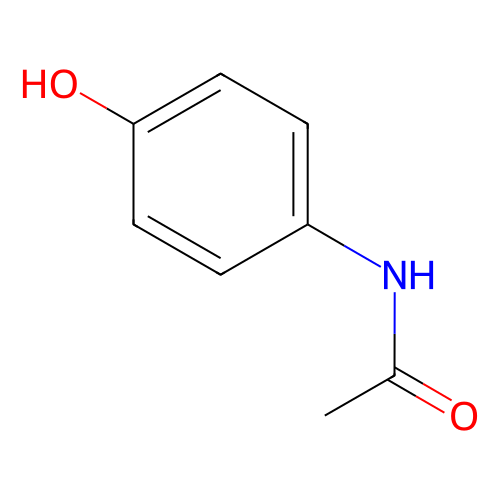

In [17]:
imagen = new_client.image
imagen.set_format('svg')
print('\033[1;30;47m' + 'Paracetamol' + '\033[0m') #Formato de texto de la etiqueta
SVG(imagen.get('CHEMBL112'))

### ***Similitud:***


Molecule ChEMBL ID: CHEMBL112
Preferred Name: ACETAMINOPHEN
Similarity: 76.9230782985687255859375


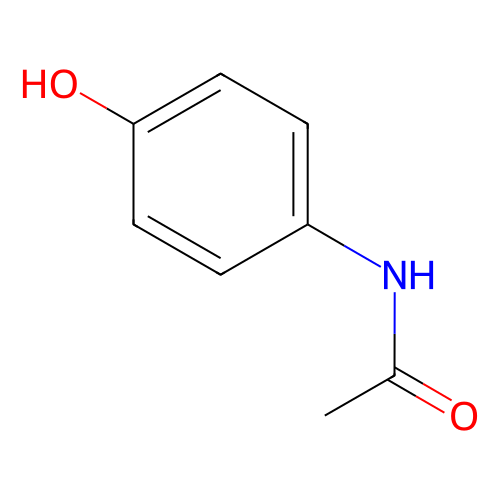



Molecule ChEMBL ID: CHEMBL1483163
Preferred Name: None
Similarity: 73.33333492279052734375


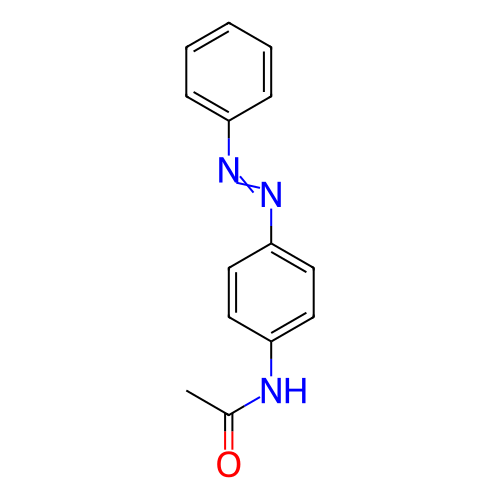



Molecule ChEMBL ID: CHEMBL311003
Preferred Name: None
Similarity: 73.33333492279052734375


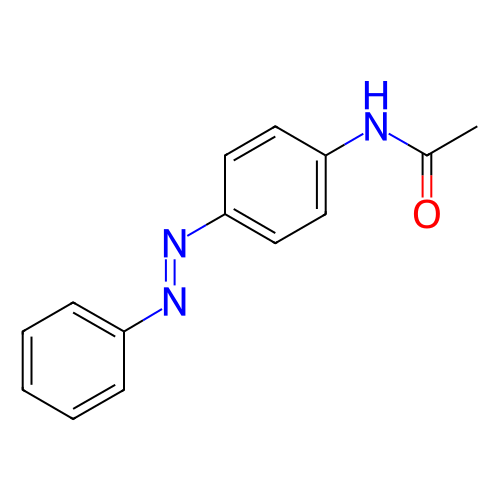



Molecule ChEMBL ID: CHEMBL3228071
Preferred Name: None
Similarity: 63.636362552642822265625


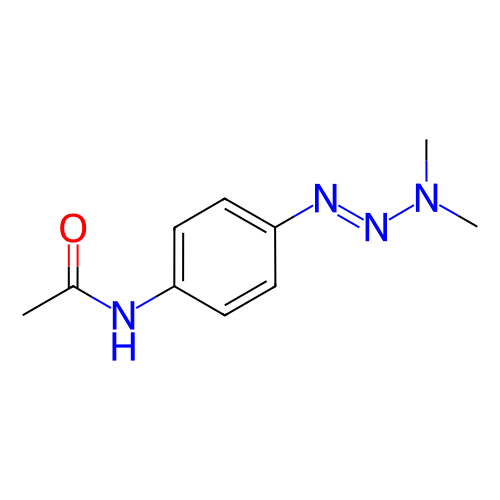



Molecule ChEMBL ID: CHEMBL82053
Preferred Name: None
Similarity: 61.1111104488372802734375


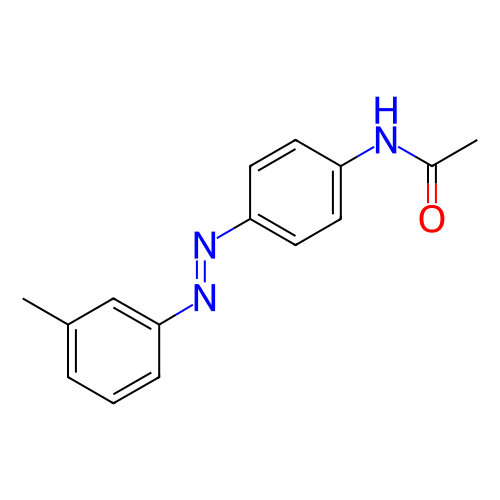



Molecule ChEMBL ID: CHEMBL1590721
Preferred Name: None
Similarity: 60.5263173580169677734375


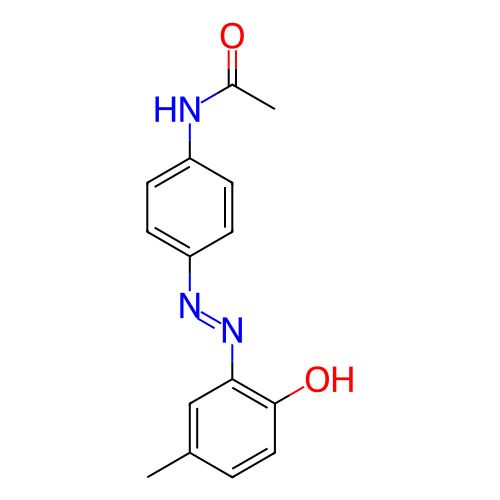

,molecule_chembl_id,pref_name,similarity,svg_image
0,CHEMBL112,ACETAMINOPHEN,76.9230782985687255859375,<?xml version='1.0' encoding='iso-8859-1'?>\n<...
1,CHEMBL1483163,None,73.33333492279052734375,<?xml version='1.0' encoding='iso-8859-1'?>\n<...
2,CHEMBL311003,None,73.33333492279052734375,<?xml version='1.0' encoding='iso-8859-1'?>\n<...
3,CHEMBL3228071,None,63.636362552642822265625,<?xml version='1.0' encoding='iso-8859-1'?>\n<...
4,CHEMBL82053,None,61.1111104488372802734375,<?xml version='1.0' encoding='iso-8859-1'?>\n<...
5,CHEMBL1590721,None,60.5263173580169677734375,<?xml version='1.0' encoding='iso-8859-1'?>\n<...


In [18]:
similitud = new_client.similarity
res = similitud.filter(chembl_id='CHEMBL1360012', #smiles="CC(=O)Nc1ccc(O)cc1" --> métrica empleada: coeficiente de tanimoto
                        similarity=60).only(['molecule_chembl_id', 'pref_name', 'similarity'])
# Crear una lista para almacenar los datos
data = []

# Iterar sobre los resultados y almacenar la información en la lista
for result in res:
    imagen.set_format('svg')

    molecule_id = result['molecule_chembl_id']
    pref_name = result['pref_name']
    similarity = result['similarity']
    svg_image = imagen.get(molecule_id)
    data.append({'molecule_chembl_id': molecule_id,
                 'pref_name': pref_name,
                 'similarity': similarity,
                 'svg_image': svg_image})

# Crear un DataFrame a partir de la lista de datos
df = pd.DataFrame(data)

# Iterar sobre el DataFrame y mostrar las imágenes SVG
for index, row in df.iterrows():
    print(f"Molecule ChEMBL ID: {row['molecule_chembl_id']}")
    print(f"Preferred Name: {row['pref_name']}")
    print(f"Similarity: {row['similarity']}")
    display(SVG(row['svg_image']))
    print("\n")

# Mostrar el DataFrame
df

### ***Subestructuras***

Número de moléculas que contienen la subestructura para el SMILES C1=CC2=C(C=C1)C1=C(C=CC=C1)C=C2: 2776


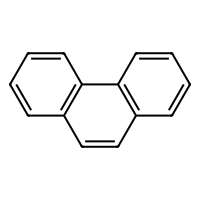

In [20]:
substructure = new_client.substructure
smiles_list = ["C1=CC2=C(C=C1)C1=C(C=CC=C1)C=C2"]  # Fenantreno
for smiles in smiles_list:
    result = substructure.filter(smiles=smiles)
    print(f"Número de moléculas que contienen la subestructura para el SMILES {smiles}: {len(result)}")
# Crear una lista de objetos de molécula RDKit a partir de los SMILES
mol_list = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
# Dibujar las moléculas
img = Draw.MolsToGridImage(mol_list, molsPerRow=1)
# Mostrar la imagen
display(img)

## ***Filtros***

### ***Compuestos bioterapéuticos***

In [22]:
bioterapeuticos = molecula.filter(biotherapeutic__isnull=False)# Campo biotherapeutic no es nulo, es decir, que tiene algún valor asignado.
len(bioterapeuticos)

23921

### ***MW<300***

In [23]:
moleculas_ligeras = molecula.filter(molecule_properties__mw_freebase__lte=300)
len(moleculas_ligeras)

448087

## ***Filtros anidados***


*Puedes* usar varios filtros anidados separados por comas:

In [24]:
#En las siguientes líneas se buscan moléculas que contengan en su nombre preferido la terminación "INE" y un MW<300
moleculas_ligeras_nib = molecula.filter(molecule_properties__mw_freebase__lte=300,
                                        pref_name__iendswith="ine").only(['molecule_chembl_id', 'pref_name'])
mol_df6= pd.DataFrame.from_records(moleculas_ligeras_nib)
mol_df6=mol_df6.sort_values(by='pref_name').reset_index(inplace=False)
print(len(mol_df6))
mol_df6[0:10]
#an,en,in,on,un

1844


,index,molecule_chembl_id,pref_name
0,346,CHEMBL298517,(+)-EPIBATIDINE
1,855,CHEMBL501778,(+)-HIGENAMINE
2,365,CHEMBL60542,(+)-PENTAZOCINE
3,408,CHEMBL76640,(+)-PHYSOSTIGMINE
4,791,CHEMBL257990,(+)-TRANYLCYPROMINE
5,1022,CHEMBL535389,(+/-)-HOMOEPIBATIDINE
6,1775,CHEMBL2414990,(+/-)-NUCIFERINE
7,1774,CHEMBL2414988,(+/-)-ROEMREFIDINE
8,174,CHEMBL440464,(+/-)NICOTINE
9,1696,CHEMBL2236571,(-)-(S)-EDULININE


In [25]:
print(len(mol_df6))
mol_df6[0:3]

1844


,index,molecule_chembl_id,pref_name
0,346,CHEMBL298517,(+)-EPIBATIDINE
1,855,CHEMBL501778,(+)-HIGENAMINE
2,365,CHEMBL60542,(+)-PENTAZOCINE


### ***Cumplimiento de guías de interés farmacéutico (Lipinski y Veber)***


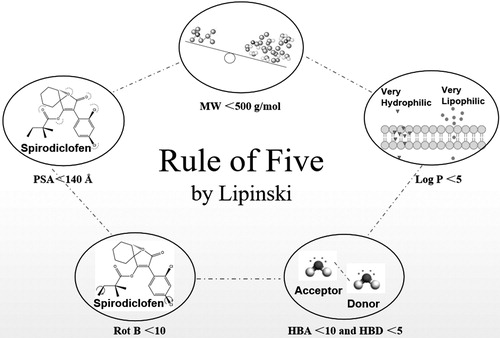

Xiaoxia Chen, Hao Li, Lichao Tian, Qinwei Li, Jinxiang Luo, and Yongqiang Zhang.
Analysis of the Physicochemical Properties of Acaricides Based on Lipinski's Rule of Five.
Journal of Computational Biology.Sep 2020.1397-1406.http://doi.org/10.1089/cmb.2019.0323

In [26]:
sin_violaciones = molecula.filter(molecule_properties__num_ro5_violations=0)
una_violacion = molecula.filter(molecule_properties__num_ro5_violations=1)
dos_violaciones = molecula.filter(molecule_properties__num_ro5_violations=2)
print(f"Moléculas que no presentan violaciones a la regla de los cinco: {len(sin_violaciones)}")
print(f"Moléculas que no presentan 1 violación: {len(una_violacion)}")
print(f"Moléculas que no presentan 2 violaciones: {len(dos_violaciones)}")

Moléculas que no presentan violaciones a la regla de los cinco: 1935757
Moléculas que no presentan 1 violación: 515957
Moléculas que no presentan 2 violaciones: 290324


---
---

<a name='1'></a>

# ***2. Fármacos***
---
---

En contraste con los compuestos, los fármacos (fase 4, max_phase=4) y los candidatos clínicos (fase 1, 2 y 3) en ChEMBL normalmente tienen información curada y no tienen que tener necesariamente mediciones de bioactividad asociada.
Los datos en la API drugs se agrega dentro del parentesco del fármaco.

## ***Obtención***

In [32]:
farmaco = new_client.drug
columnas=['development_phase','first_approval','molecule_chembl_id','synonyms',
          'usan_stem','usan_stem_definition',  'usan_year']
res = farmaco.only(columnas)
farmaco_df1= pd.DataFrame.from_records(res)
farmaco_df1 #10 min

KeyboardInterrupt: 

## ***Filtros***

#### ***Año de liberación, sinónimos y palabras clave de los sinónimos***

El "**USAN**" (United States Adopted Names) es un sistema para designar nombres genéricos para los medicamentos en los Estados Unidos. Los nombres USAN son seleccionados por la American Medical Association (**AMA**) y otras organizaciones. Un "**stem**" en este contexto se refiere a una parte común de un nombre de medicamento que indica su clase o categoría.
Corresponde a la designación de nombres genéricos de medicamentos.

In [28]:
farmaco = new_client.drug
res = farmaco.filter(first_approval__gte=1980).filter(usan_stem="-azosin").only(['development_phase',
                                                                                 'first_approval','molecule_chembl_id',
                                                                                 'synonyms','usan_stem',
                                                                                 'usan_stem_definition','usan_year'])
farmaco_df2= pd.DataFrame.from_records(res)
farmaco_df2

,applicants,atc_code_description,first_approval,molecule_chembl_id,research_codes,synonyms,usan_stem,usan_stem_definition,usan_year
0,None,None,1987,CHEMBL611,None,"[Terazosin (BAN, INN, MI), Terazosin hydrochlo...",-azosin,antihypertensives (prazosin type),1980
1,None,None,1987,CHEMBL611,None,"[Terazosin (BAN, INN, MI), Terazosin hydrochlo...",-azosin,antihypertensives (prazosin type),1980
2,None,None,1990,CHEMBL707,None,"[Doxazosin mesilate (JAN), Doxazosin mesylate ...",-azosin,antihypertensives (prazosin type),1981


#### ***Fase clínica máxima, clasificación [ATC](http://www.vademecumfarmacia.com/clasificacion-atc-de-medicamentos/) y año de aprobación***
A continuación se considera la búsqueda de fármacos aprobados teniendo en cuenta la fase clínica máxima 4, la denominación ATC para inmunosupresores y el año de aprobación correspondiente.

In [30]:
farmacos_aprobados = molecula.filter(max_phase=4, #solo fármacos aprobados
                                atc_classifications__level4='N03AA', #Clasificación ATC de ANTIEPILÉPTICOS (Barbitúricos y derivados)
                                      #level2: N03, level3: N03A, level4: N03A A
                                #first_approval__gte=2024 #Aprobados despues del 2024 )
                                ).order_by('first_approval').only(['atc_classifications','first_approval','indication_class','max_phase','pref_name','molecule_type', 'molecule_chembl_id'])
farmaco_df2= pd.DataFrame.from_records(farmacos_aprobados)
farmaco_df2

,atc_classifications,first_approval,max_phase,molecule_chembl_id,molecule_type,pref_name
0,[N03AA03],1954,4.0,CHEMBL856,Small molecule,PRIMIDONE
1,[N03AA03],1954,4.0,CHEMBL856,Small molecule,PRIMIDONE
2,[N03AA30],1982,4.0,CHEMBL450,Small molecule,METHARBITAL
3,[N03AA02],2022,4.0,CHEMBL40,Small molecule,PHENOBARBITAL


## ***Identificación de:***


#### ***Moléculas considerando enfermedades***
A continuación se considera la búsqueda de fármacos que se encuentren en fase clínica 3 para una enfermedad particular, en este caso se considera al cáncer de pulmón.

In [31]:
indicacion_farmaceutica = new_client.drug_indication
diabetes_indicacion = indicacion_farmaceutica.filter(efo_term__icontains="diabetes")
diabetes_indicacion_df= pd.DataFrame.from_records(diabetes_indicacion)
print(len(diabetes_indicacion_df))
diabetes_indicacion_df[0:2]

847


,drugind_id,efo_id,efo_term,indication_refs,max_phase_for_ind,mesh_heading,mesh_id,molecule_chembl_id,parent_molecule_chembl_id
0,22612,EFO:0000400,diabetes mellitus,"[{'ref_id': 'A10BF01', 'ref_type': 'ATC', 'ref...",4.0,Diabetes Mellitus,D003920,CHEMBL404271,CHEMBL404271
1,22612,EFO:0000400,diabetes mellitus,"[{'ref_id': 'A10BF01', 'ref_type': 'ATC', 'ref...",4.0,Diabetes Mellitus,D003920,CHEMBL404271,CHEMBL404271


In [33]:
print(diabetes_indicacion_df['mesh_heading'].unique())

['Diabetes Mellitus' 'Diabetes, Gestational' 'Prediabetic State'
 'Diabetes Insipidus' 'Latent Autoimmune Diabetes in Adults'
 'Diabetes Insipidus, Neurogenic' 'Diabetes Mellitus, Type 1'
 'Diabetes Mellitus, Type 2' 'Diabetes Complications']


In [34]:
print(diabetes_indicacion_df['max_phase_for_ind'].unique())

['4.0' '2.0' '1.0' '3.0' '0.5' '-1.0']


In [ ]:
diabetes_fase3 = molecula.filter(molecule_chembl_id__in=[x['molecule_chembl_id'] for x in diabetes_indicacion]).only(['molecule_chembl_id','molecule_properties'])
diabetes_fase3 = pd.DataFrame(diabetes_fase3)
print(len(diabetes_fase3))
diabetes_fase3[0:2]

587


,molecule_chembl_id,molecule_properties
0,CHEMBL269538,"{'alogp': '3.03', 'aromatic_rings': 3, 'full_m..."
1,CHEMBL406,"{'alogp': '2.08', 'aromatic_rings': 2, 'full_m..."


In [37]:
#Las propiedades que pueden ser extraídas son las siguientes:
properties = diabetes_fase3['molecule_properties'].iloc[0]
print(json.dumps(properties, indent=4))

{
    "alogp": "3.03",
    "aromatic_rings": 3,
    "full_molformula": "C13H12N2O",
    "full_mwt": "212.25",
    "hba": 2,
    "hbd": 1,
    "heavy_atoms": 16,
    "mw_freebase": "212.25",
    "np_likeness_score": "0.29",
    "num_ro5_violations": 0,
    "psa": "37.91",
    "qed_weighted": "0.67",
    "ro3_pass": "N",
    "rtb": 1
}


In [39]:
# Desglosar las propiedades fisicoquímicas de interés de las moléculas que cumplen con los filtros previos
def desglose_informacion(df, column_name_output, column_name_input):
    df[column_name_output] = df[column_name_input].apply(lambda x: x.get(column_name_output) if isinstance(x, dict) else None)
    return df

# Desglosar información de las propiedades fisicoquímicas
properties_to_desglose = ['mw_freebase', 'alogp', 'aromatic_rings', 'full_molformula', 'hba', 'hbd', 'heavy_atoms',
                          'molecular_species', 'num_lipinski_ro5_violations', 'psa', 'rtb']
for property_name in properties_to_desglose:
    diabetes_fase3 = desglose_informacion(diabetes_fase3, property_name, 'molecule_properties')
diabetes_fase3

,molecule_chembl_id,molecule_properties,mw_freebase,alogp,aromatic_rings,full_molformula,hba,hbd,heavy_atoms,molecular_species,num_lipinski_ro5_violations,psa,rtb
0,CHEMBL269538,"{'alogp': '3.03', 'aromatic_rings': 3, 'full_m...",212.25,3.03,3.0,C13H12N2O,2.0,1.0,16.0,None,None,37.91,1.0
1,CHEMBL406,"{'alogp': '2.08', 'aromatic_rings': 2, 'full_m...",365.84,2.08,2.0,C16H16ClN3O3S,4.0,2.0,24.0,None,None,92.50,3.0
2,CHEMBL408,"{'alogp': '4.37', 'aromatic_rings': 2, 'full_m...",441.55,4.37,2.0,C24H27NO5S,6.0,2.0,31.0,None,None,84.86,5.0
3,CHEMBL13,"{'alogp': '1.61', 'aromatic_rings': 1, 'full_m...",267.37,1.61,1.0,C15H25NO3,4.0,2.0,19.0,None,None,50.72,9.0
4,CHEMBL413,"{'alogp': '6.18', 'aromatic_rings': 0, 'full_m...",914.19,6.18,0.0,C51H79NO13,13.0,3.0,65.0,None,None,195.43,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
582,CHEMBL6068334,"{'alogp': '2.02', 'aromatic_rings': 2, 'full_m...",407.32,2.02,2.0,C16H18ClF6N5O2,5.0,1.0,28.0,None,None,77.04,4.0
583,CHEMBL6068392,"{'alogp': '3.38', 'aromatic_rings': 4, 'full_m...",566.67,3.38,4.0,C31H34N8O3,8.0,3.0,42.0,None,None,128.37,8.0
584,CHEMBL6068462,None,None,None,NaN,None,NaN,NaN,NaN,None,None,None,NaN
585,CHEMBL6068559,"{'alogp': '3.53', 'aromatic_rings': 1, 'full_m...",228.34,3.53,1.0,C15H20N2,2.0,0.0,17.0,None,None,25.78,1.0


### ***Mecanismo de acción***
A continuación se realiza la búsqueda de moléculas interactuantes con un blanco (receptor de insulina) y se identifica su respectivo mecanismo de acción.

In [41]:
mecanismo = new_client.mechanism
columns= ['action_type','max_phase','mechanism_comment',
          'mechanism_of_action','molecule_chembl_id', 'target_chembl_id']
res = mecanismo.filter(target_chembl_id='CHEMBL1981' #Receptor de insulina
                      ).only(columns)
farmaco_df3= pd.DataFrame.from_records(res)
farmaco_df3

,action_type,max_phase,mechanism_comment,mechanism_of_action,molecule_chembl_id,target_chembl_id
0,AGONIST,4,None,Insulin receptor agonist,CHEMBL1201540,CHEMBL1981
1,AGONIST,4,None,Insulin receptor agonist,CHEMBL1201540,CHEMBL1981
2,AGONIST,4,None,Insulin receptor agonist,CHEMBL1201629,CHEMBL1981
3,AGONIST,4,None,Insulin receptor agonist,CHEMBL1201644,CHEMBL1981
4,AGONIST,4,None,Insulin receptor agonist,CHEMBL1201631,CHEMBL1981
5,AGONIST,4,None,Insulin receptor agonist,CHEMBL1201630,CHEMBL1981
6,AGONIST,4,None,Insulin receptor agonist,CHEMBL1201545,CHEMBL1981
7,AGONIST,4,None,Insulin receptor agonist,CHEMBL1201611,CHEMBL1981
8,AGONIST,4,None,Insulin receptor agonist,CHEMBL1201538,CHEMBL1981
9,AGONIST,4,None,Insulin receptor agonist,CHEMBL1201613,CHEMBL1981


### ***Alertas farmacéuticas***
A continuación se realiza la búsqueda de compuestos que hayan presentado algún tipo de alerta farmacéutica de interés.

In [42]:
alerta_farmaco = new_client.drug_warning
res = alerta_farmaco.filter(warning_type='Withdrawn',
                            warning_class='carcinogenicity') #carcinogenicity, neurotoxicity
farmaco_df4= pd.DataFrame.from_records(res)
farmaco_df4

,efo_id,efo_id_for_warning_class,efo_term,molecule_chembl_id,parent_molecule_chembl_id,warning_class,warning_country,warning_description,warning_id,warning_refs,warning_type,warning_year
0,EFO:0011046,EFO:0011046,carcinogenicity,CHEMBL110691,CHEMBL110691,carcinogenicity,United States; United Kingdom; Italy,Animal carcinogenicity (dogs),3869,[{'ref_id': 'CFR-2019-title21-vol4/pdf/CFR-201...,Withdrawn,1970
1,EFO:0011046,EFO:0011046,carcinogenicity,CHEMBL110691,CHEMBL110691,carcinogenicity,United States; United Kingdom; Italy,Animal carcinogenicity (dogs),3869,[{'ref_id': 'CFR-2019-title21-vol4/pdf/CFR-201...,Withdrawn,1970
2,EFO:0011046,EFO:0011046,carcinogenicity,CHEMBL2105827,CHEMBL2105827,carcinogenicity,United States,Increased occurrence of cancer,3900,"[{'ref_id': 'FR-1998-10-08/html/98-26923.htm',...",Withdrawn,1993
3,EFO:0011046,EFO:0011046,carcinogenicity,CHEMBL1322884,CHEMBL1322884,carcinogenicity,Oman,Potential risk of carcinogenicity,3929,"[{'ref_id': 'EDM-QSM-2001.3', 'ref_type': 'WHO...",Withdrawn,1997
4,EFO:0011046,EFO:0011046,carcinogenicity,CHEMBL2107519,CHEMBL2107519,carcinogenicity,Denmark,Carcinogenic especially in the bladder,3985,"[{'ref_id': 'CL12.pdf', 'ref_type': 'WHO', 're...",Withdrawn,1964
5,EFO:0011046,EFO:0011046,carcinogenicity,CHEMBL44618,CHEMBL44618,carcinogenicity,United States; Turkey; Japan; Italy; Canada; P...,Carcinogenicity in rats,3986,"[{'ref_id': 'CL12.pdf', 'ref_type': 'WHO', 're...",Withdrawn,1976
6,EFO:0011046,EFO:0011046,carcinogenicity,CHEMBL340978,CHEMBL340978,carcinogenicity,Worldwide,Liver necrosis; Photosensitivity; Animal carci...,4030,"[{'ref_id': '10.1177/009286150103500134', 'ref...",Withdrawn,1982
7,EFO:0011046,EFO:0011046,carcinogenicity,CHEMBL46917,CHEMBL46917,carcinogenicity,Oman,Potential risk of carcinogenicity,4046,"[{'ref_id': 'EDM-QSM-2001.3', 'ref_type': 'WHO...",Withdrawn,1997
8,EFO:0011046,EFO:0011046,carcinogenicity,CHEMBL63857,CHEMBL63857,carcinogenicity,Oman; Canada; Saudi Arabia,May cause cancer,4069,[{'ref_id': 'recall-alert-rappel-avis/hc-sc/20...,Withdrawn,1997
9,EFO:0011046,EFO:0011046,carcinogenicity,CHEMBL1525,CHEMBL1525,carcinogenicity,Oman,Potential risk of carcinogenicity,4085,"[{'ref_id': 'EDM-QSM-2001.3', 'ref_type': 'WHO...",Withdrawn,1997


#### ***Tipo de alerta***
Se puede realizar la búsqueda a partir de una palabra clave.

In [43]:
res = alerta_farmaco.filter(warning_class__icontains='cardio')#, warning_type='Black Box Warning')
farmaco_df5= pd.DataFrame.from_records(res)
farmaco_df5

,efo_id,efo_id_for_warning_class,efo_term,molecule_chembl_id,parent_molecule_chembl_id,warning_class,warning_country,warning_description,warning_id,warning_refs,warning_type,warning_year
0,None,EFO:1001482,None,CHEMBL270190,CHEMBL270190,cardiotoxicity,United States,None,81,[{'ref_id': '77a67dc6-35d3-48ff-9d18-292d4d442...,Black Box Warning,NaN
1,None,EFO:1001482,None,CHEMBL270190,CHEMBL270190,cardiotoxicity,United States,None,81,[{'ref_id': '77a67dc6-35d3-48ff-9d18-292d4d442...,Black Box Warning,NaN
2,None,EFO:1001482,None,CHEMBL1083993,CHEMBL633,cardiotoxicity,United States,None,98,[{'ref_id': '730039c2-0a32-4775-855d-98b2207e9...,Black Box Warning,NaN
3,None,EFO:1001482,None,CHEMBL501,CHEMBL405,cardiotoxicity,United States,None,109,[{'ref_id': 'f469fb38-0380-4621-9db3-a4f429126...,Black Box Warning,NaN
4,None,EFO:1001482,None,CHEMBL5483015,CHEMBL5483015,cardiotoxicity,United States,None,135,[{'ref_id': 'a482eccd-8837-47ea-904d-2f2c294d1...,Black Box Warning,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
253,None,EFO:1001482,None,CHEMBL3989698,CHEMBL3989843,cardiotoxicity,United States,None,5200,[],Black Box Warning,NaN
254,None,EFO:1001482,None,CHEMBL3646221,CHEMBL3646221,cardiotoxicity,United States,None,5206,[],Black Box Warning,NaN
255,None,EFO:1001482,None,CHEMBL1069,CHEMBL1069,cardiotoxicity,United States,None,5207,[],Black Box Warning,NaN
256,None,EFO:1001482,None,CHEMBL1201066,CHEMBL637,cardiotoxicity,United States,None,5212,[],Black Box Warning,NaN


---
---

<a name='2'></a>

# ***3. Blancos moleculares***
---
---

Igual que en los casos anteriores, la búsqueda de un blanco molecular se puede realizar a partir de diferentes rutas.
Para los siguientes ejemplos consideraremos a G9a, una lisin-metiltransferasa de histonas involucrada en modificaciones epigenéticas de importancia.


## ***Búsqueda a partir del:***

### ***Nombre de un gen***

In [44]:
blanco_molecular = new_client.target
gene_name = 'G9a'
res = blanco_molecular.filter(target_synonym__icontains=gene_name)#.only(['organism', 'pref_name', 'target_type'])
for i in res:
    print(i)

{'cross_references': [], 'organism': 'Homo sapiens', 'pref_name': 'Histone-lysine N-methyltransferase EHMT1', 'species_group_flag': False, 'target_chembl_id': 'CHEMBL6031', 'target_components': [{'accession': 'Q9H9B1', 'component_description': 'Histone-lysine N-methyltransferase EHMT1', 'component_id': 4552, 'component_type': 'PROTEIN', 'relationship': 'SINGLE PROTEIN', 'target_component_synonyms': [{'component_synonym': '2.1.1.-', 'syn_type': 'EC_NUMBER'}, {'component_synonym': '2.1.1.367', 'syn_type': 'EC_NUMBER'}, {'component_synonym': 'EHMT1', 'syn_type': 'GENE_SYMBOL'}, {'component_synonym': 'Euchromatic histone-lysine N-methyltransferase 1', 'syn_type': 'UNIPROT'}, {'component_synonym': 'Eu-HMTase1', 'syn_type': 'UNIPROT'}, {'component_synonym': 'EUHMTASE1', 'syn_type': 'GENE_SYMBOL_OTHER'}, {'component_synonym': 'G9a-like protein 1', 'syn_type': 'UNIPROT'}, {'component_synonym': 'GLP', 'syn_type': 'GENE_SYMBOL_OTHER'}, {'component_synonym': 'GLP', 'syn_type': 'UNIPROT'}, {'compo

### ***Uniprot_id***
El ID de [Uniprot](https://www.uniprot.org/) para G9a es *Q96KQ7*.


In [45]:
blanco_molecular = new_client.target
actividad = new_client.activity

uniprot_id = 'Q9Z148'
res = blanco_molecular.filter(xref_id__iexact=uniprot_id).only('target_chembl_id')[0]
print(res)
act = actividad.filter(target_chembl_id=res['target_chembl_id']).filter(standard_type='IC50')
print(len(act))
activity= pd.DataFrame.from_records(act)
activity

{'target_chembl_id': 'CHEMBL2074'}
429


,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,None,306817,[],CHEMBL649260,Inhibitory activity measured against alpha-glu...,B,None,None,BAO_0000190,...,Homo sapiens,Maltase-glucoamylase,9606,None,None,IC50,uM,UO_0000065,None,110.0
1,None,None,306817,[],CHEMBL649260,Inhibitory activity measured against alpha-glu...,B,None,None,BAO_0000190,...,Homo sapiens,Maltase-glucoamylase,9606,None,None,IC50,uM,UO_0000065,None,110.0
2,None,None,314789,[],CHEMBL649260,Inhibitory activity measured against alpha-glu...,B,None,None,BAO_0000190,...,Homo sapiens,Maltase-glucoamylase,9606,None,None,IC50,uM,UO_0000065,None,0.7
3,None,None,314800,[],CHEMBL649260,Inhibitory activity measured against alpha-glu...,B,None,None,BAO_0000190,...,Homo sapiens,Maltase-glucoamylase,9606,None,None,IC50,uM,UO_0000065,None,3.2
4,None,None,333819,[],CHEMBL649260,Inhibitory activity measured against alpha-glu...,B,None,None,BAO_0000190,...,Homo sapiens,Maltase-glucoamylase,9606,None,None,IC50,uM,UO_0000065,None,0.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425,"{'action_type': 'INHIBITOR', 'description': 'N...",None,26023876,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5581100,Inhibition of alpha-glucosidase (unknown origi...,B,None,None,BAO_0000190,...,Homo sapiens,Maltase-glucoamylase,9606,None,None,IC50,uM,UO_0000065,None,5.9
426,"{'action_type': 'INHIBITOR', 'description': 'N...",None,26023877,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5581100,Inhibition of alpha-glucosidase (unknown origi...,B,None,None,BAO_0000190,...,Homo sapiens,Maltase-glucoamylase,9606,None,None,IC50,uM,UO_0000065,None,12.25
427,"{'action_type': 'INHIBITOR', 'description': 'N...",None,26023878,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5581100,Inhibition of alpha-glucosidase (unknown origi...,B,None,None,BAO_0000190,...,Homo sapiens,Maltase-glucoamylase,9606,None,None,IC50,uM,UO_0000065,None,564.28
428,"{'action_type': 'INHIBITOR', 'description': 'N...",None,26039059,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5585478,Inhibition of intestinal alpha-glucosidase (un...,B,None,None,BAO_0000190,...,Homo sapiens,Maltase-glucoamylase,9606,None,None,IC50,uM,UO_0000065,None,42.45


### ***Nombre de la proteína***

In [46]:
protein_name = 'dnmt'
res = blanco_molecular.filter(pref_name__icontains=protein_name).only(['organism','pref_name',
                                                                       'target_chembl_id',
                                                                       'target_type']).order_by(['pref_name','organism'])
blancos_df2= pd.DataFrame.from_records(res)
blancos_df2

,organism,pref_name,target_chembl_id,target_type
0,Homo sapiens,DNMT3A2/3L complex,CHEMBL3137291,PROTEIN COMPLEX
1,Homo sapiens,DNMT3A2/3L complex,CHEMBL3137291,PROTEIN COMPLEX
2,Mus musculus,DNMT3A-DNMT3L,CHEMBL5483092,PROTEIN COMPLEX
3,Homo sapiens,DNMT3B-DNMT3L complex,CHEMBL3885560,PROTEIN COMPLEX


---
---

<a name='3'></a>

# ***4. Actividades***
---
---

Con el siguiente módulo es posible obtener toda la información asociada a la actividad reportada para un compuesto o para un blanco molecular.
A continuación se obtendrán las actividades reportadas (IC50) asociadas a un blanco.


In [48]:
actividad = new_client.activity
blanco_molecular = new_client.target

blanco_molecular = blanco_molecular.filter(pref_name__icontains='DNMT').only('target_chembl_id')[0]
print(blanco_molecular)
blanco_molecular_con_actividades = actividad.filter(target_chembl_id=blanco_molecular['target_chembl_id'])#.filter(standard_type="IC50")
len(blanco_molecular_con_actividades)


{'target_chembl_id': 'CHEMBL3137291'}


108

Se puede obtener todas las actividades reportadas para un blanco especifico considerando ensayos de unión (tipo B).

In [49]:
res = actividad.filter(target_chembl_id='CHEMBL3137291', assay_type='B') #,pchembl_value__isnull=False)
print(len(res))
assay_b= pd.DataFrame.from_records(res)
assay_b

108


,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,None,13957093,[],CHEMBL3129168,Inhibition of human DNMT3A2/3L using unmethyla...,B,None,None,BAO_0000190,...,Homo sapiens,DNMT3A2/3L complex,9606,None,None,IC50,uM,UO_0000065,None,18.0
1,None,None,13957093,[],CHEMBL3129168,Inhibition of human DNMT3A2/3L using unmethyla...,B,None,None,BAO_0000190,...,Homo sapiens,DNMT3A2/3L complex,9606,None,None,IC50,uM,UO_0000065,None,18.0
2,None,None,13957094,[],CHEMBL3129168,Inhibition of human DNMT3A2/3L using unmethyla...,B,None,None,BAO_0000190,...,Homo sapiens,DNMT3A2/3L complex,9606,None,None,IC50,uM,UO_0000065,None,27.0
3,None,None,13957095,[],CHEMBL3129168,Inhibition of human DNMT3A2/3L using unmethyla...,B,None,None,BAO_0000190,...,Homo sapiens,DNMT3A2/3L complex,9606,None,None,IC50,uM,UO_0000065,None,2.8
4,None,None,13957096,[],CHEMBL3129168,Inhibition of human DNMT3A2/3L using unmethyla...,B,None,None,BAO_0000190,...,Homo sapiens,DNMT3A2/3L complex,9606,None,None,IC50,uM,UO_0000065,None,42.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,None,None,25979751,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5546275,Inhibition of DNMT3A/DNMT3L (unknown origin) u...,B,None,None,BAO_0000201,...,Homo sapiens,DNMT3A2/3L complex,9606,None,None,INH,%,UO_0000187,None,20.0
105,None,Not Active,26214360,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5649093,Inhibition of DNMT3A/DNMT3L (unknown origin) a...,B,None,None,BAO_0000201,...,Homo sapiens,DNMT3A2/3L complex,9606,None,None,INH,None,UO_0000187,None,None
106,None,Not Active,26216002,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5650117,Inhibition of DNMT3A/3L (unknown origin) at 1 ...,B,None,None,BAO_0000201,...,Homo sapiens,DNMT3A2/3L complex,9606,None,None,INH,None,UO_0000187,None,None
107,None,Not Active,26228907,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5657514,Inhibition of DNMT3A/3L (unknown origin) at 1 ...,B,None,None,BAO_0000201,...,Homo sapiens,DNMT3A2/3L complex,9606,None,None,INH,None,UO_0000187,None,None


---
---

<a name='4'></a>

# ***5. Ensayos***
---
---

A continuación, se lleva a cabo una búsqueda de ensayos de inhibición relacionados con ADMET (tipo A), medidos en organismos específicos.

A:  Ensayo de actividad.

B: Ensayo de unión.

C: Ensayo celular.

D: Ensayo de dosis-respuesta.

F: Ensayo funcional.

L: Ensayo de ligando radiactivo.

M: Ensayo metabólico.

T: Ensayo de transporte.

U: Otros tipos de ensayos.


In [50]:
ensayo = new_client.assay
res = ensayo.filter(description__icontains='inhibit', assay_type='A',
                    assay_organism='Rattus norvegicus').only(['assay_chembl_id',
                                                              'assay_organism',
                                                              'description'])
ensayos_df1= pd.DataFrame.from_records(res)
ensayos_df1

,assay_chembl_id,assay_organism,description
0,CHEMBL884521,Rattus norvegicus,Inhibition of cytochrome P450 progesterone 15-...
1,CHEMBL884521,Rattus norvegicus,Inhibition of cytochrome P450 progesterone 15-...
2,CHEMBL615148,Rattus norvegicus,Inhibition of cytochrome P450 progesterone 16-...
3,CHEMBL615199,Rattus norvegicus,Inhibition of cytochrome P450 progesterone 2-a...
4,CHEMBL883800,Rattus norvegicus,Inhibition of progesterone 6-beta-hydroxylase ...
...,...,...,...
655,CHEMBL5638230,Rattus norvegicus,Inhibition of CYP2C19 in rat liver microsomes ...
656,CHEMBL5638231,Rattus norvegicus,Inhibition of CYP2D6 in rat liver microsomes a...
657,CHEMBL5638232,Rattus norvegicus,Inhibition of CYP2E1 in rat liver microsomes a...
658,CHEMBL5638233,Rattus norvegicus,Inhibition of CYP3A4 in rat liver microsomes a...


## ***Toxicidad***
A continuación se muestra cómo se pueden encontrar ensayos que evalúan algún tipo de toxicidad a través del módulo *drug_warning*.

In [51]:
res = ensayo.filter(description__icontains='kidney').only(['assay_chembl_id', #Búsqueda de toxicidad en riñón.
                                                                               'assay_organism','description'])
ensayos_df2= pd.DataFrame.from_records(res)
ensayos_df2

,assay_chembl_id,assay_organism,description
0,CHEMBL827088,None,Percent inhibition against 11-beta-hydroxyster...
1,CHEMBL827088,None,Percent inhibition against 11-beta-hydroxyster...
2,CHEMBL615234,None,Percent inhibition against 11-beta-hydroxyster...
3,CHEMBL615699,Sus scrofa,"Percent inhibition was measured against 5,10-M..."
4,CHEMBL615700,Sus scrofa,"Percent inhibition was measured against 5,10-M..."
...,...,...,...
8386,CHEMBL5738698,Homo sapiens,Opioid Receptor Binding Assay: The measurement...
8387,CHEMBL5738699,Homo sapiens,Opioid Receptor Binding Assay: The measurement...
8388,CHEMBL5739361,Homo sapiens,Radioligand Binding Assay: The affinity of the...
8389,CHEMBL5739381,Homo sapiens,MATE2-K IC50 Assay: MATE2-K (multidrug and tox...


---
---

<a name='5'></a>

# ***6. Utilidades***
---
---

[ChEMBL Chemoinformatic Utils](https://www.ebi.ac.uk/chembl/api/utils/docs) (también conocido como '**ChEMBL Beaker**') es un conjunto de herramientas de utilidad web que proporcionan acceso RESTful a métodos quimioinformáticos comúnmente utilizados. Muchos de ellos utilizan la biblioteca quimioinformática *RDKit*.

Incluye:
* Herramientas de estandarización de estructuras químicas (por ejemplo, verificar, obtener el padre, estandarizar; ver [Bento et al](https://github.com/chembl/ChEMBL_Structure_Pipeline).)
* Cálculo de propiedades físico-químicas (por ejemplo, peso molecular, recuento de átomos pesados, número de donantes/aceptores de enlaces de hidrógeno, número de anillos aromáticos, etc.)
* Convertidores de formato de estructuras químicas (por ejemplo, de archivo mol a SMILES, de InChI a InChIKey, etc.)
* Otras herramientas para alertas estructurales, similitud de moléculas y visualización de moléculas.

Da click en la siguiente liga para mayor información: https://chembl.gitbook.io/chembl-interface-documentation/web-services/cheminformatic-utils-web-services

### ***Descriptores moleculares***

In [ ]:
aspirina = utils.smiles2ctab('O=C(Oc1ccccc1C(=O)O)C')
print(aspirina)


     RDKit          2D

 13 13  0  0  0  0  0  0  0  0999 V2000
   -1.8012   -1.1888    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
   -1.7990   -0.1888    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.9320    0.3096    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
   -0.0672   -0.1922    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.0690   -1.1922    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.7960   -1.6940    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    1.6630   -1.1956    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    1.6650   -0.1956    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.8000    0.3062    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.8020    1.3060    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.0630    1.8078    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
    1.6690    1.8042    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
   -2.6640    0.3130    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
  1  2  2  0
  2  3  1  0

In [ ]:
aspirina = utils.smiles2ctab('O=C(Oc1ccccc1C(=O)O)C')
descs = json.loads(utils.chemblDescriptors(aspirina))[0]
df = pd.DataFrame.from_records([descs])
df

,qed,MolWt,TPSA,HeavyAtomCount,NumAromaticRings,NumHAcceptors,NumHDonors,NumRotatableBonds,MolLogP,MolecularFormula,Ro3Pass,NumRo5,MonoisotopicMolWt
0,0.550122,180.159,63.6,13,1,3,1,2,1.3101,C9H8O4,0,0,180.042259


### ***Alertas estructurales***

In [ ]:
alerts = json.loads(utils.structuralAlerts(aspirina))
for a in alerts[0]:
    print(a)

{'alert_id': 1030, 'alert_name': 'Ester', 'set_name': 'MLSMR', 'smarts': '[#6]-C(=O)O-[#6]'}
{'alert_id': 1069, 'alert_name': 'vinyl michael acceptor1', 'set_name': 'MLSMR', 'smarts': '[#6]-[CH1]=C-C(=O)[#6,#7,#8]'}


## ***Estandarizar una molécula***

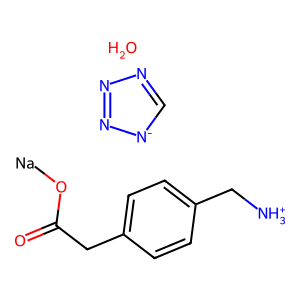

In [12]:
#Crear la molécula desde un SMILES (RDKit) --- Componentes separados por "."
smiles= '[Na]OC(=O)Cc1ccc(C[NH3+])cc1.c1nnn[n-]1.O' #'CC(C)(C)OC(=O)C1=CC(=C(C=C1)O)OCCCN2CCN(CC2)C(=O)C3=CC=CC=C3.[Cl-]'
molecula= Chem.MolFromSmiles(smiles) #Sal iónica compuesta --> Carboxilato + tetrazolato + Hidrato
Draw.MolToImage(molecula)

In [13]:
#Convertir SMILES a CTAB (molfile)
mol = utils.smiles2ctab(smiles)
st = json.loads(utils.standardize(mol))
st

[{'standard_molblock': '\n     RDKit          2D\n\n 19 17  0  0  0  0  0  0  0  0999 V2000\n   -1.4275   -2.9831    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0\n   -4.9566   -0.4188    0.0000 Na  0  0  0  0  0 15  0  0  0  0  0  0\n   -4.0888   -0.9158    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0\n   -3.2246   -0.4126    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -3.2282    0.5874    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0\n   -2.3568   -0.9096    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -1.4926   -0.4064    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.6248   -0.9034    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.2394   -0.4002    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.2360    0.5998    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    1.1000    1.1028    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    1.9680    0.6060    0.0000 N   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.6320    1.0968    0.0000 C   0  0  0  0  0  0  0 

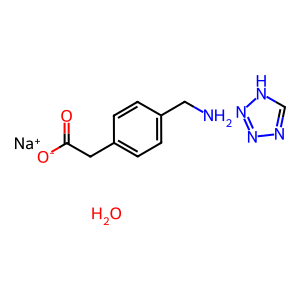

In [14]:
# Obtener el molblock de la molécula
molblock = st[0]['standard_molblock']
# Convertir el molblock en una molécula RDKit
st_mol = Chem.MolFromMolBlock(molblock)
# Dibujar la molécula
Draw.MolToImage(st_mol)

---
---

<a name='6'></a>

# ***7. Ejercicio general***
---
---



A continuación se desarrollará un ejercicio global partiendo de la búsqueda de moléculas pequeñas en los fármacos aprobados (fase clínica 4), seguido del desglose de sus propiedades para finalizar con el curado (aplicación de filtros) al dataframe obtenido.
Imagina que

In [ ]:
actividad = new_client.activity
blanco_molecular = new_client.target
molecula=new_client.molecule

In [ ]:
# Filtrar los fármacos aprobados por fase máxima 3 o 4
columns= ['oral','parenteral','topical', 'molecule_properties'#'black_box_warning',
          'canonical_smiles','first_approval','indication_class', 'molecule_structures'
           'max_phase','pref_name','molecule_type', 'molecule_chembl_id']
moleculas_F_3_4 = molecula.filter(max_phase__in=[3, 4]).only(columns)
moleculas_F_3_4= pd.DataFrame.from_records(moleculas_F_3_4)
moleculas_F_3_4['canonical_smiles'] = moleculas_F_3_4.loc[ moleculas_F_3_4['molecule_structures'].notnull(), 'molecule_structures'].apply(lambda x: x['canonical_smiles']) #This is the mwt of the parent compound
print(moleculas_F_3_4.info()) #5 min

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5989 entries, 0 to 5988
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   first_approval       3790 non-null   float64
 1   max_phase            5989 non-null   object 
 2   molecule_chembl_id   5989 non-null   object 
 3   molecule_properties  4653 non-null   object 
 4   molecule_structures  4488 non-null   object 
 5   molecule_type        5989 non-null   object 
 6   oral                 5989 non-null   bool   
 7   parenteral           5989 non-null   bool   
 8   pref_name            5989 non-null   object 
 9   topical              5989 non-null   bool   
 10  canonical_smiles     4488 non-null   object 
dtypes: bool(3), float64(1), object(7)
memory usage: 392.0+ KB
None


In [ ]:
organism_name = 'coronavirus'
records = blanco_molecular.filter(organism__icontains=organism_name).only(['organism','pref_name',
                                                                       'target_chembl_id',
                                                                       'target_type']).order_by(['pref_name','organism'])
SARS_df= pd.DataFrame.from_records(records)
#SARS_df = SARS_df[SARS_df['target_type']=='ORGANISM']
list_id = SARS_df['target_chembl_id'].tolist()

list_id

['CHEMBL6066646',
 'CHEMBL6066646',
 'CHEMBL5291668',
 'CHEMBL613732',
 'CHEMBL612744',
 'CHEMBL613837',
 'CHEMBL5209665',
 'CHEMBL4296578',
 'CHEMBL5209664',
 'CHEMBL3232681',
 'CHEMBL5169223',
 'CHEMBL6067603',
 'CHEMBL3232683',
 'CHEMBL3927',
 'CHEMBL4295624',
 'CHEMBL4888440',
 'CHEMBL4295557',
 'CHEMBL4523582',
 'CHEMBL5118',
 'CHEMBL5604041',
 'CHEMBL4303836',
 'CHEMBL4303835',
 'CHEMBL4802007',
 'CHEMBL4662936',
 'CHEMBL4888460',
 'CHEMBL6067604']

In [ ]:
# Lista de columnas que se desean recuperar
info = ['activity_id', 'assay_chembl_id', 'assay_description', 'canonical_smiles',
        'document_chembl_id', 'document_journal', 'ligand_efficiency',
        'molecule_chembl_id', 'standard_units', 'standard_value',
        'target_chembl_id', 'target_organism', 'target_pref_name']

# Inicializar un DataFrame vacío para almacenar los resultados
all_activity_records = []

# Iterar sobre los identificadores de blancos moleculares
for target_id in list_id:
    # Filtrar los registros de actividad para el blanco molecular actual
    target_activity_records = actividad.filter(target_chembl_id='CHEMBL4802007', assay_type='B').only(info)
    print(f"El blanco {target_id} presenta {len(target_activity_records)} reportes")
    # Agregar los registros de actividad a la lista general
    all_activity_records.extend(target_activity_records)

# Construir un DataFrame con todos los registros de actividad
coronavirus_compounds = pd.DataFrame.from_records(all_activity_records)
# Mostrar las primeras tres filas del DataFrame resultante
print(f'Cantidad total de reportes para los coronavirus {len(coronavirus_compounds)}')
coronavirus_compounds[0:3]

El blanco CHEMBL6066646 presenta 20 reportes
El blanco CHEMBL6066646 presenta 20 reportes
El blanco CHEMBL5291668 presenta 20 reportes
El blanco CHEMBL613732 presenta 20 reportes
El blanco CHEMBL612744 presenta 20 reportes
El blanco CHEMBL613837 presenta 20 reportes
El blanco CHEMBL5209665 presenta 20 reportes
El blanco CHEMBL4296578 presenta 20 reportes
El blanco CHEMBL5209664 presenta 20 reportes
El blanco CHEMBL3232681 presenta 20 reportes
El blanco CHEMBL5169223 presenta 20 reportes
El blanco CHEMBL6067603 presenta 20 reportes
El blanco CHEMBL3232683 presenta 20 reportes
El blanco CHEMBL3927 presenta 20 reportes
El blanco CHEMBL4295624 presenta 20 reportes
El blanco CHEMBL4888440 presenta 20 reportes
El blanco CHEMBL4295557 presenta 20 reportes
El blanco CHEMBL4523582 presenta 20 reportes
El blanco CHEMBL5118 presenta 20 reportes
El blanco CHEMBL5604041 presenta 20 reportes
El blanco CHEMBL4303836 presenta 20 reportes
El blanco CHEMBL4303835 presenta 20 reportes
El blanco CHEMBL480

,activity_id,assay_chembl_id,assay_description,canonical_smiles,document_chembl_id,document_journal,ligand_efficiency,molecule_chembl_id,standard_units,standard_value,target_chembl_id,target_organism,target_pref_name,units,value
0,22850677,CHEMBL4723465,Inhibition of spike protein in SARS-CoV infect...,CC(C)C[C@H](NC(=O)CNC(=O)[C@H](CO)NC(=O)[C@H](...,CHEMBL4715856,Bioorg Med Chem,"{'bei': '1.94', 'le': None, 'lle': None, 'sei'...",CHEMBL4785828,nM,100.0,CHEMBL4802007,Severe acute respiratory syndrome coronavirus,Spike glycoprotein,uM,0.1
1,23157422,CHEMBL4811846,Inhibition of spike glycoprotein S in SARS-CoV...,C[C@@H]1O[C@@H](O[C@H]2[C@H](O[C@H]3CC[C@]4(C)...,CHEMBL4811231,Eur J Med Chem,"{'bei': '4.81', 'le': '0.09', 'lle': '0.42', '...",CHEMBL4849021,nM,18120.0,CHEMBL4802007,Severe acute respiratory syndrome coronavirus,Spike glycoprotein,uM,18.12
2,23157423,CHEMBL4811846,Inhibition of spike glycoprotein S in SARS-CoV...,COc1ccccc1NC(=O)[C@]12CCC(C)(C)C[C@H]1C1=CC[C@...,CHEMBL4811231,Eur J Med Chem,"{'bei': '5.17', 'le': None, 'lle': None, 'sei'...",CHEMBL4847112,nM,5540.0,CHEMBL4802007,Severe acute respiratory syndrome coronavirus,Spike glycoprotein,uM,5.54


In [ ]:
  print(f"El blanco {target_id} presenta {len(target_activity_records)} reportes")
  # Agregar los registros de actividad a la lista general
  all_activity_records.extend(target_activity_records)

El blanco CHEMBL6067604 presenta 20 reportes


In [ ]:
df_concatenado = pd.merge(left=moleculas_F_3_4, right=coronavirus_compounds, how='inner' )
#Filtros
print(f"Fármacos en fase 4 y 3: {len(df_concatenado)}")
small_molecules= df_concatenado[ df_concatenado['molecule_type']=='Small molecule']
print(f"Moléculas pequeñas en fase 4 y 3: {len(small_molecules)}")
small_molecules=small_molecules.drop_duplicates(subset='canonical_smiles', keep='first').reset_index(drop=True)
print(f"Moléculas pequeñas sin duplicados en fase 4 y 3: {len(small_molecules)}")
small_molecules.to_excel('chembl_search_output.xlsx')
small_molecules.to_csv('chembl_search_output.csv') #Guardar dataframe en un archivo tipo excel
print(small_molecules.info())

Fármacos en fase 4 y 3: 0
Moléculas pequeñas en fase 4 y 3: 0
Moléculas pequeñas sin duplicados en fase 4 y 3: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   first_approval       0 non-null      float64
 1   max_phase            0 non-null      object 
 2   molecule_chembl_id   0 non-null      object 
 3   molecule_properties  0 non-null      object 
 4   molecule_structures  0 non-null      object 
 5   molecule_type        0 non-null      object 
 6   oral                 0 non-null      bool   
 7   parenteral           0 non-null      bool   
 8   pref_name            0 non-null      object 
 9   topical              0 non-null      bool   
 10  canonical_smiles     0 non-null      object 
 11  activity_id          0 non-null      int64  
 12  assay_chembl_id      0 non-null      object 
 13  assay_description    0 non-null      ob

In [ ]:
#Orden de columnas
small_molecules=small_molecules[['molecule_chembl_id','pref_name','canonical_smiles',
                 'oral','parenteral','topical','first_approval',]]#'indication_class'

---
---

<a name='7'></a>

# ***8. Ejercicios de práctica***
---
---

Realiza las siguientes búsquedas, considerando que cada punto no es secuencial:

1. A partir del nombre “ibuprofeno”, obtén la información asociada al nombre preferido, el ID de ChEMBL, los sinónimos de la molécula, la fase clínica  máxima, la clasificación ATC, la información asociada a la estructura molecular y la información asociada a las propiedades moleculares.


2. ¿Cuántas moléculas en ChEMBL contienen la subestructura correspondiente a la quinazolina (SMILES: C1=CC=C2C(=C1)C=NC=N2)?


3. Identifica la cantidad de las moléculas que tienen más del 75% de similitud con el naproxeno, así cómo la/las moléculas con mayor similitud.


4. ¿Cuántas moléculas se encuentran en fase clínica 3 considerando todo ChEMBL?


5. ¿Cuántas moléculas están catalogadas como NO bioterapeuticas considerando todo ChEMBL?


Ejercicio global:
1. Selecciona un blanco molecular de tu interés, preferiblemente una proteína.
2. Obtén el ID de ese blanco a través de UniProt.
3. Obtén los blancos moleculares asociados a ese ID de Uniprot empleando la API.


4. Descarga los datos de actividad asociados a los target_chembl_id obtenidos en el paso anterior, considerando únicamente las siguientes columnas: "molecule_chembl_id", "canonical_smiles", "standard_value", "standard_units", "target_chembl_id" y "target_organism".


In [ ]:
columns = ["molecule_chembl_id", "canonical_smiles", "standard_value", "standard_units",
           "target_chembl_id", "target_organism"]

5. Utilizando los "molecule_chembl_id" obtenidos, recopila la información molecular de todas las entradas previamente obtenidas y genera un DataFrame.


6. Aplica los siguientes filtros al DataFrame resultante:
   - Elimina los duplicados basados en los SMILES canónicos.
   - Conserva las moléculas que no violen ninguna de las cinco reglas de Lipinski (molecule_properties__num_ro5_violations=0).


# **Referencias y otras ligas de interés:**
1. [Servidor web de ChEMBL](https://www.ebi.ac.uk/chembl/)
2. [Esquema de ChEMBL](https://ftp.ebi.ac.uk/pub/databases/chembl/ChEMBLdb/latest/chembl_33_schema.png)
3. [Adquisición de datos de ChEMBL de TeachOpenCADD(consultarlo para mayor información)](https://projects.volkamerlab.org/teachopencadd/talktorials/T001_query_chembl.html)
4. [Script de obtención de información de ChEMBL por Leela S. Dodda](https://gist.github.com/leelasd/746f3c447805fc6ea5aad1071bd77aef)
5. [Documentación de la API de ChEMBL](https://www.ebi.ac.uk/chembl/api/utils/docs)
6. [Otros ejemplos del uso de la API](https://github.com/chembl/notebooks/blob/main/ChEMBL_API_example_for_webinar.ipynb)
